In [1]:
import numpy as np
import pandas as pd
import matplotlib
import scipy.sparse as sp
from lightfm import LightFM, cross_validation, evaluation

%matplotlib inline

/Users/afetisov/anaconda/envs/BD/lib/python3.6/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [2]:
movies_df = pd.read_csv(r"ml-1m/movies.dat", delimiter="::", engine="python",
                        names=["id", "name", "genre"], index_col=0, header=None)

In [3]:
ratings_df = pd.read_csv(r"ml-1m/ratings.dat", delimiter="::", engine="python", 
                        names=["user_id", "movie_id", "rating", "timestamp"], header=None)

In [4]:
users_df = pd.read_csv(r"ml-1m/users.dat", delimiter="::", engine="python",
                      names=["id", "gender", "age", "occupation", "zip"], index_col=0, header=None)

### EDA

#### Movies

In [5]:
movies_df.head()

,name,genre
id,,
1,Toy Story (1995),Animation|Children's|Comedy
2,Jumanji (1995),Adventure|Children's|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama
5,Father of the Bride Part II (1995),Comedy


In [6]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3883 entries, 1 to 3952
Data columns (total 2 columns):
name     3883 non-null object
genre    3883 non-null object
dtypes: object(2)
memory usage: 91.0+ KB


Genre field doesn't look too convinient to work with, let's replace it with a set

In [7]:
movies_df["genre"] = movies_df.genre.apply(lambda x: frozenset(x.split("|")))

There're two possible approaches:  
- treat every genre combination as a unique feature
- treat every genre as a separate feature

In [8]:
len(movies_df.genre.unique())

301

So there're 301 unique genre combinations

A little helper class that will allow to sum over genres sets to get a set of all genres

In [9]:
class set_plus(set):
    def __init__(self, s):
        self.__set = s
    
    def __add__(self, other):
        return self.__set | other
    
    def __radd__(self, other):
        return self.__add__(other)

In [10]:
all_unique_genres = movies_df.genre.apply(lambda x: set_plus(x)).sum()
print(" ".join(all_unique_genres))
print(len(all_unique_genres))

Film-Noir Animation Fantasy Crime War Drama Horror Documentary Musical Western Sci-Fi Adventure Children's Mystery Comedy Action Romance Thriller
18


And only 18 genres  
For the sake of performance, it's better to go the latter way

A quick glance into genres count per movie

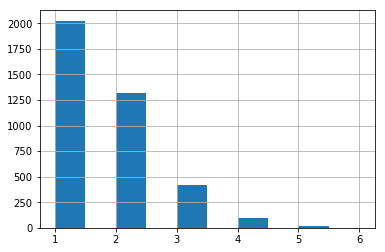

In [11]:
movies_df.genre.apply(lambda x: len(x)).hist()

#### Users

In [12]:
users_df.head()

,gender,age,occupation,zip
id,,,,
1,F,1,10,48067
2,M,56,16,70072
3,M,25,15,55117
4,M,45,7,02460
5,M,25,20,55455


In [13]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6040 entries, 1 to 6040
Data columns (total 4 columns):
gender        6040 non-null object
age           6040 non-null int64
occupation    6040 non-null int64
zip           6040 non-null object
dtypes: int64(2), object(2)
memory usage: 235.9+ KB


##### Age

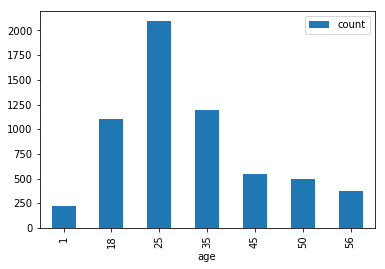

In [14]:
users_df.groupby("age").age.agg(["count"]).plot(kind="bar")

##### Occupation

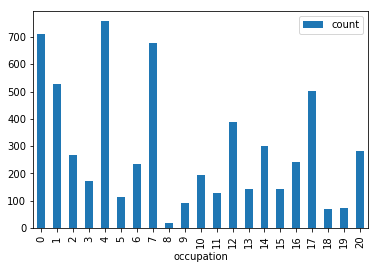

In [15]:
users_df.groupby("occupation").occupation.agg(["count"]).plot(kind="bar")

##### Gender

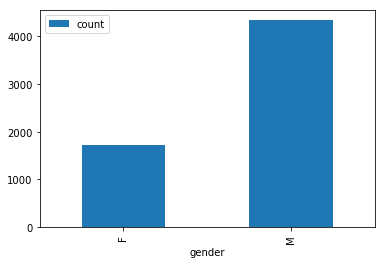

In [16]:
users_df.groupby("gender").gender.agg(["count"]).plot(kind="bar")

#### Ratings

In [17]:
ratings_df.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [18]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
user_id      1000209 non-null int64
movie_id     1000209 non-null int64
rating       1000209 non-null int64
timestamp    1000209 non-null int64
dtypes: int64(4)
memory usage: 30.5 MB


##### Ratings count per user

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1174819b0>]], dtype=object)

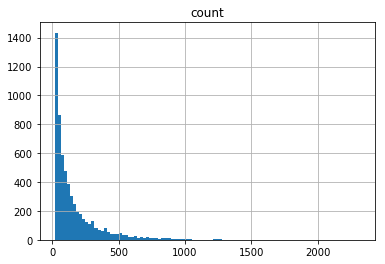

In [19]:
ratings_df.groupby("user_id").user_id.agg(["count"]).hist(bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117454a20>]], dtype=object)

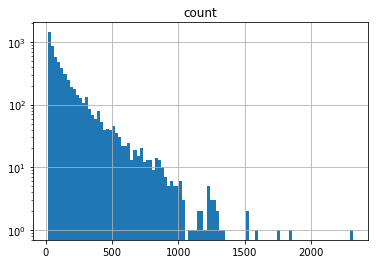

In [20]:
ratings_df.groupby("user_id").user_id.agg(["count"]).hist(bins=100, log=True)

##### Ratings count per movie

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11c1d3ef0>]], dtype=object)

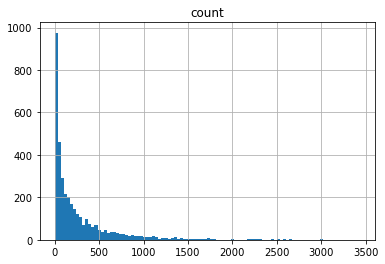

In [21]:
ratings_df.groupby("movie_id").movie_id.agg(["count"]).hist(bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11c1d3320>]], dtype=object)

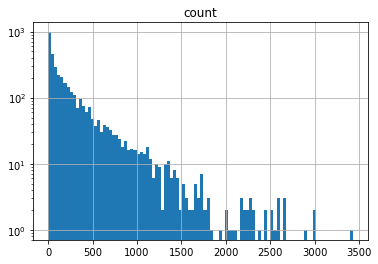

In [22]:
ratings_df.groupby("movie_id").movie_id.agg(["count"]).hist(bins=100, log=True)

##### Mean rating

In [23]:
mean_rating = ratings_df.rating.mean()
mean_rating

3.5815644530293169

##### Diif with mean rating distribution by movies

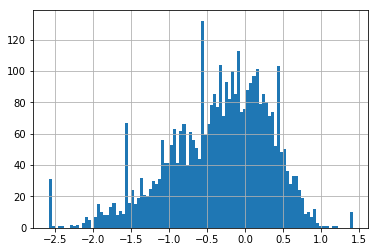

In [24]:
movies_diff_with_mean = ratings_df.groupby("movie_id").rating.mean() - mean_rating
movies_diff_with_mean.hist(bins=100)

In [25]:
movies_diff_with_mean.describe()

count    3706.000000
mean       -0.342672
std         0.672925
min        -2.581564
25%        -0.758860
50%        -0.250018
75%         0.159176
max         1.418436
Name: rating, dtype: float64

IQR of movies' ratings difference with mean rating is 0.918036

In [26]:
sum(abs(movies_diff_with_mean) <= 0.5) / len(movies_diff_with_mean)

0.55963302752293576

~56% of movies' ratings lie in an interval 3.58±0.5

##### Mean rating by movie

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x116683a90>]], dtype=object)

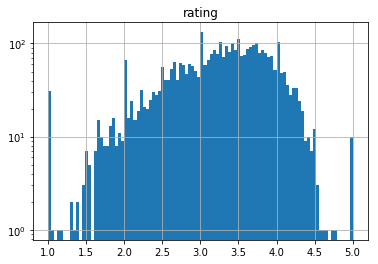

In [27]:
ratings_df.groupby("movie_id").agg({"rating" : "mean"}).hist(bins=100, log=True)

##### Diif with mean rating distribution by users

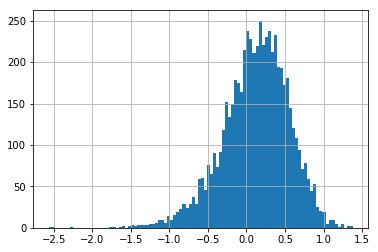

In [28]:
users_diff_with_mean = ratings_df.groupby("user_id").rating.mean() - mean_rating
users_diff_with_mean.hist(bins=100)

In [29]:
users_diff_with_mean.describe()

count    6040.000000
mean        0.121140
std         0.429622
min        -2.566180
25%        -0.137120
50%         0.153730
75%         0.418436
max         1.381399
Name: rating, dtype: float64

IQR of users' ratings difference with mean rating is 0.555556

In [30]:
sum(abs(users_diff_with_mean) <= 0.5) / len(users_diff_with_mean)

0.73261589403973515

~73% of users' ratings lie in an interval 3.58±0.5

##### Mean rating by user

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1184b0f60>]], dtype=object)

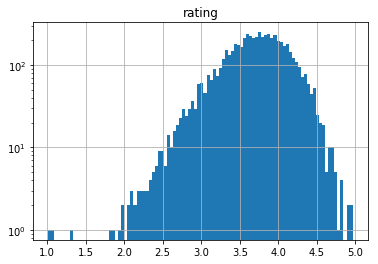

In [31]:
ratings_df.groupby("user_id").agg({"rating" : "mean"}).hist(bins=100, log=True)

##### Movies, that everyone (dis)likes

Let's define a criteria for "everyone likes" and "everyone dislikes".  
First of all, "everyone". Obviously the entire population can't be "everyone", because not every member of this population is even aware about every single movie, let alone watching or rating it. So "everyone" in this context should mean "every user that rated this movie".  
Next one, "likes". We have only one way of saying whether user likes something or not - rating, it makes sense to consider 4.0 and 5.0 as a "like". The same principle applies to "dislikes": 1.0 and 2.0 quite clearly indicate that a user doesn't like a movie.  
Considering everything aforementioned, we define "movie that everyone likes" as a movie, that has no ratings other than 4.0 and 5.0 and "movie that everyone dislikes" as a movie, that has no ratings other than 1.0 and 2.0.

In [32]:
min_rating = ratings_df.groupby("movie_id").agg({"rating": "min"})
max_rating = ratings_df.groupby("movie_id").agg({"rating": "max"})

In [33]:
everyone_likes = min_rating[min_rating.rating > 3]
everyone_dislikes = max_rating[max_rating.rating < 3]

In [34]:
everyone_likes.merge(movies_df, left_index=True, right_index=True)[["name"]]

,name
53,Lamerica (1994)
134,Sonic Outlaws (1995)
139,Target (1995)
396,Fall Time (1995)
398,Frank and Ollie (1995)
439,Dangerous Game (1993)
557,Mamma Roma (1962)
578,"Hour of the Pig, The (1993)"
584,I Don't Want to Talk About It (De eso no se ha...
624,Condition Red (1995)


In [35]:
everyone_dislikes.merge(movies_df, left_index=True, right_index=True)[["name"]]

,name
127,"Silence of the Palace, The (Saimt el Qusur) (1..."
133,Nueba Yol (1995)
142,Shadows (Cienie) (1988)
226,Dream Man (1995)
545,Harlem (1993)
579,"Scorta, La (1993)"
641,"Little Indian, Big City (Un indien dans la vil..."
642,Roula (1995)
644,Happy Weekend (1996)
651,"Superweib, Das (1996)"


##### Best movies

Let's define "best movies" as top ten movies sorted by their mean rating that have more than 1000 ratings.

In [36]:
means_and_counts = movies_df.merge(ratings_df, left_index=True, right_on="movie_id") \
                            .groupby("name").agg({"rating": ["mean", "count"]})
means_and_counts[means_and_counts.rating["count"] >= 1000].sort_values(("rating", "mean"), ascending=False).head(10)

rating      
                                                        mean count
name                                                              
Shawshank Redemption, The (1994)                    4.554558  2227
Godfather, The (1972)                               4.524966  2223
Usual Suspects, The (1995)                          4.517106  1783
Schindler's List (1993)                             4.510417  2304
Raiders of the Lost Ark (1981)                      4.477725  2514
Rear Window (1954)                                  4.476190  1050
Star Wars: Episode IV - A New Hope (1977)           4.453694  2991
Dr. Strangelove or: How I Learned to Stop Worry...  4.449890  1367
Casablanca (1942)                                   4.412822  1669
Sixth Sense, The (1999)                             4.406263  2459

### Model

In [37]:
df = users_df.merge(ratings_df, left_index=True, right_on="user_id") \
             .merge(movies_df, left_on="movie_id", right_index=True)

Interaction is a combination of a movie, a user and their rating for this movie.

In [38]:
def get_interactions(df):
    max_user_id_plus_one = df.user_id.max() + 1
    max_movie_id_plus_one = df.movie_id.max() + 1
    
    interactions = sp.lil_matrix((max_user_id_plus_one, max_movie_id_plus_one), dtype=np.float32)
    
    for row in df.itertuples():
        user_id = row.user_id
        movie_id = row.movie_id
        rating = row.rating
        
        interactions[user_id, movie_id] = rating
    
    return interactions.tocsr()

Users' metadata contains information about every user's gender, age and occupation OHE format. It alco contains identity matrix, that improves expressive ability of a model.  
To simplify the process it's reasonable to create rows from 0 to max(user_id) even if some user ids are missing. Anyway, it won't take too much memory, thanks to sparse representation.

In [39]:
def get_users_meta(df):
    max_user_id_plus_one = df.user_id.max() + 1
    
    unique_genders = sorted(df.gender.unique())
    genders_map = dict(zip(unique_genders, range(len(unique_genders))))
    
    unique_ages = sorted(df.age.unique())
    ages_map = dict(zip(unique_ages, range(len(unique_ages))))
    
    unique_occupations = sorted(df.occupation.unique())
    occupations_map = dict(zip(unique_occupations, range(len(unique_occupations))))
    
    genders = sp.lil_matrix((max_user_id_plus_one, len(unique_genders)), dtype=np.float32)
    ages = sp.lil_matrix((max_user_id_plus_one, len(unique_ages)))
    occupations = sp.lil_matrix((max_user_id_plus_one, len(unique_occupations)))
    identity = sp.identity(max_user_id_plus_one, format='csr', dtype=np.float32)
    
    for row in df.itertuples():
        user_id = row.user_id
        gender = row.gender
        age = row.age
        occupation = row.occupation
        
        gender_index = genders_map[gender]
        age_index = ages_map[age]
        occupation_index = occupations_map[occupation]
        
        genders[user_id, gender_index] = 1.0
        ages[user_id, age_index] = 1.0
        occupations[user_id, occupation_index] = 1.0
        
    return sp.hstack([genders, ages, occupations, identity]).tocsr(), {"genders": genders_map, 
                                                                       "ages": ages_map, 
                                                                       "occupations": occupations_map}

Movies' metadata contains information about every movie's genre and, also, an identity matrix.

In [40]:
def get_movies_meta(df):
    max_movie_id_plus_one = df.movie_id.max() + 1

    unique_genres = sorted(df.genre.apply(lambda x: set_plus(x)).sum())
    genres_map = dict(zip(unique_genres, range(len(unique_genres))))
    
    genres = sp.lil_matrix((max_movie_id_plus_one, len(unique_genres)), dtype=np.float32)
    identity = sp.identity(max_movie_id_plus_one, format='csr', dtype=np.float32)
    
    for row in df.itertuples():
        movie_id = row.movie_id
        genre = row.genre
        
        for g in genre:
            genre_index = genres_map[g]
            genres[movie_id, genre_index] = 1.0
    
    return sp.hstack([genres, identity]).tocsr(), {"genre": genres_map}

In [41]:
interactions = get_interactions(df)
users_meta, user_meta_maps = get_users_meta(df)
movies_meta, movies_meta_maps = get_movies_meta(df)

Due to the API limitations, it's not feasible to implement standard grid search. But, anyway, there's not many parameters to tune and all of them comply with "the more, the merrier" principle.

In [42]:
def prepare_model(interactions, users_meta, movies_meta, model=None):
    partial = model is not None
    
    if partial:
        new_model = model.fit_partial(interactions=interactions, user_features=users_meta, item_features=movies_meta)
    else:
        np.random.seed(0)
        train, test = cross_validation.random_train_test_split(interactions, test_percentage=0.2, random_state=np.random)
        lfm = LightFM(loss="warp", no_components=100, max_sampled=100)    
        new_model = lfm.fit(interactions=train, user_features=users_meta, item_features=movies_meta, epochs=20)
        
        train_auc = evaluation.auc_score(new_model, train, user_features=users_meta, item_features=movies_meta)
        test_auc = evaluation.auc_score(new_model, test, user_features=users_meta, item_features=movies_meta)
        train_precision_at_10 = evaluation.precision_at_k(new_model, train, user_features=users_meta, item_features=movies_meta, k=10)
        test_precision_at_10 = evaluation.precision_at_k(new_model, test, user_features=users_meta, item_features=movies_meta, k=10)
        train_recall_at_10 = evaluation.recall_at_k(new_model, train, user_features=users_meta, item_features=movies_meta, k=10)
        test_recall_at_10 = evaluation.recall_at_k(new_model, test, user_features=users_meta, item_features=movies_meta, k=10)
    
        print("AUC\n\ttrain: {}\n\ttest: {}".format(train_auc.mean(), test_auc.mean()))
        print("Precision (percentage of relevant items in prediction) at 10\n\ttrain: {}\n\ttest: {}"
              .format(train_precision_at_10.mean(), test_precision_at_10.mean()))
        print("Recall (number of  relevant items in prediction / total number of relevant items) at 10\n\ttrain: {}\n\ttest: {}"
              .format(train_recall_at_10.mean(), test_recall_at_10.mean()))
    
    return new_model

In [43]:
model = prepare_model(interactions, users_meta, movies_meta)

AUC
	train: 0.9686875939369202
	test: 0.9172576069831848
Precision (percentage of relevant items in prediction) at 10
	train: 0.7802648544311523
	test: 0.07333444058895111
Recall (number of  relevant items in prediction / total number of relevant items) at 10
	train: 0.13340108671264864
	test: 0.050520121134023564


In [44]:
def add_new_user(gender, age, occupation, users_meta, user_meta_maps, interactions, for_full_refit=False):
    new_user = sp.lil_matrix((1, users_meta.shape[1]), dtype=np.float32)
    new_user[0, user_meta_maps["genders"][gender]] = 1.0
    new_user[0, len(user_meta_maps["genders"]) + user_meta_maps["ages"][age]] = 1.0
    new_user[0, len(user_meta_maps["genders"]) + len(user_meta_maps["ages"]) + user_meta_maps["occupations"][occupation]] = 1.0
    
    new_users_meta = sp.vstack([users_meta, new_user])
    new_interactions = sp.vstack([interactions, sp.lil_matrix((1, interactions.shape[1]))])
    
    # identity feature improves model predictions, but makes fit_partial impossible
    if for_full_refit:
        new_user_identity = sp.lil_matrix((new_users_meta.shape[0], 1), dtype=np.float32)
        new_user_identity[-1, 0] = 1.0
        new_users_meta = sp.hstack([new_users_meta, new_user_identity])
    
    return (new_users_meta.shape[0] - 1, new_users_meta, new_interactions)

In [45]:
def add_ratings_for_user_manual(user_id, interactions, movies_df):
    print("1-5 to rate a movie, 0 to skip, anything else to stop")
    new_interactions = interactions.tolil()
    while True:
        movie_id = np.random.choice(movies_df.index)
        title = movies_df.loc[movie_id]["name"]
        try:
            rating = float(int(input(title + ":\n")))
            if rating < 1.0 or rating > 5.0:
                break
            elif rating == 0.0:
                continue
        except:
            break
               
        new_interactions[user_id, movie_id] = rating
    return new_interactions.tocsr()

In [46]:
def add_ratings_for_user(n, user_id, interactions, movies_df):
    new_interactions = interactions.tolil()
    for _ in range(n):
        movie_id = np.random.choice(movies_df.index)
        rating = np.random.randint(1, 5)
        new_interactions[user_id, movie_id] = rating
        
    return new_interactions.tocsr()

In [47]:
new_user_id, new_users_meta, new_interactions_empty = add_new_user("M", 25, 12, users_meta, user_meta_maps, interactions)
new_model = prepare_model(new_interactions_empty, new_users_meta, movies_meta, model)

Let's check what's on the menu for our new user without any interactions from their side

In [48]:
predictions_without_ratigs = new_model.predict(new_user_id, np.array(range(new_interactions_empty.shape[1])), 
                                               user_features=new_users_meta, 
                                               item_features=movies_meta)

print ("Top-20 recommended movies without any ratings from the new user\n")
for ind, movie_id in enumerate(predictions_without_ratigs.argsort()[-20:][::-1]):
    print(ind+1, movies_df.loc[movie_id]["name"])

Top-20 recommended movies without any ratings from the new user

1 Star Wars: Episode V - The Empire Strikes Back (1980)
2 Star Wars: Episode VI - Return of the Jedi (1983)
3 Terminator 2: Judgment Day (1991)
4 Matrix, The (1999)
5 Star Wars: Episode IV - A New Hope (1977)
6 Star Wars: Episode I - The Phantom Menace (1999)
7 Men in Black (1997)
8 Jurassic Park (1993)
9 Terminator, The (1984)
10 Back to the Future (1985)
11 Total Recall (1990)
12 Raiders of the Lost Ark (1981)
13 Princess Bride, The (1987)
14 Saving Private Ryan (1998)
15 American Beauty (1999)
16 E.T. the Extra-Terrestrial (1982)
17 Blade Runner (1982)
18 Silence of the Lambs, The (1991)
19 Aliens (1986)
20 Independence Day (ID4) (1996)


In [49]:
new_interactions = add_ratings_for_user_manual(new_user_id, new_interactions_empty, movies_df)

1-5 to rate a movie, 0 to skip, anything else to stop
Retro Puppetmaster (1999):
1
Orlando (1993):
2
Ilsa, She Wolf of the SS (1974):
4
Matrix, The (1999):
5
Duel in the Sun (1946):
1
Tetsuo II: Body Hammer (1992):
2
Illuminata (1998):
3
Hoogste tijd (1995):
4
Ballad of Ramblin' Jack, The (2000):
5
Half Baked (1998):
-1


And now with some movies rated

In [50]:
new_model_with_ratings = prepare_model(new_interactions, new_users_meta, movies_meta, model)
predictions_with_ratings = new_model_with_ratings.predict(new_user_id, np.array(range(new_interactions.shape[1])), 
                                                            user_features=new_users_meta, 
                                                            item_features=movies_meta)

print ("Top-20 recommended movies with ratings from the new user\n")
for ind, movie_id in enumerate(predictions_with_ratings.argsort()[-20:][::-1]):
    print(ind+1, movies_df.loc[movie_id]["name"])

Top-20 recommended movies with ratings from the new user

1 Star Wars: Episode V - The Empire Strikes Back (1980)
2 Star Wars: Episode VI - Return of the Jedi (1983)
3 Terminator 2: Judgment Day (1991)
4 Matrix, The (1999)
5 Star Wars: Episode IV - A New Hope (1977)
6 Star Wars: Episode I - The Phantom Menace (1999)
7 Men in Black (1997)
8 Jurassic Park (1993)
9 Terminator, The (1984)
10 Back to the Future (1985)
11 Total Recall (1990)
12 Raiders of the Lost Ark (1981)
13 Saving Private Ryan (1998)
14 Princess Bride, The (1987)
15 American Beauty (1999)
16 Blade Runner (1982)
17 E.T. the Extra-Terrestrial (1982)
18 Independence Day (ID4) (1996)
19 Silence of the Lambs, The (1991)
20 Alien (1979)


From some changes in recommendations we can conclude, that the recommender system is functional (-ish).  
Recommendations are, apparently, mostly based on the user's metadata, but they adjust as new ratings are added.